IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time

LOADING AND EXPLORING DATA

In [2]:
# Using telecom customer churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("Data Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df = pd.get_dummies(df, columns=['gender', 'Partner', 'Dependents', 'PhoneService',
                                 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies', 'Contract',
                                 'PaperlessBilling', 'PaymentMethod'], drop_first=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Data Shape: (7043, 21)

Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     o

MODEL TRAINING WITH HYPERPARAMETER TUNING

In [8]:
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    }),
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    "SVM": (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }),
    "Gradient Boosting": (GradientBoostingClassifier(), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    })
}

results = {}
best_model = None
best_f1 = 0

for name, (model, params) in models.items():
    print(f"\n=== Tuning {name} ===")
    start_time = time()

    # Calculate total parameter combinations
    total_combinations = 1
    for v in params.values():
        total_combinations *= len(v)

    # Choose search method based on parameter space size
    if total_combinations <= 24:  # Use GridSearch for small spaces
        print(f"Using GridSearchCV ({total_combinations} combinations)")
        search = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    else:
        n_iter = min(15, total_combinations)  # Don't exceed total combinations
        print(f"Using RandomizedSearchCV ({n_iter}/{total_combinations} combinations)")
        search = RandomizedSearchCV(model, params, n_iter=n_iter, cv=5,
                                   scoring='f1', n_jobs=-1, random_state=42)

    search.fit(X_train, y_train)

    best_estimator = search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'best_params': search.best_params_,
        'train_time': time() - start_time
    }

    results[name] = metrics

    if metrics['f1'] > best_f1:
        best_model = best_estimator
        best_f1 = metrics['f1']

    print(f"Best F1: {metrics['f1']:.4f}")
    print(f"Best Params: {search.best_params_}")


=== Tuning Logistic Regression ===
Using GridSearchCV (10 combinations)
Best F1: 0.6040
Best Params: {'C': 10, 'solver': 'saga'}

=== Tuning Random Forest ===
Using GridSearchCV (18 combinations)
Best F1: 0.5527
Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

=== Tuning SVM ===
Using GridSearchCV (12 combinations)
Best F1: 0.5904
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

=== Tuning Gradient Boosting ===
Using GridSearchCV (8 combinations)
Best F1: 0.5649
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

=== Tuning KNN ===
Using GridSearchCV (8 combinations)
Best F1: 0.5562
Best Params: {'n_neighbors': 9, 'weights': 'uniform'}


RESULTS ANALYSIS


MODEL PERFORMANCE COMPARISON:
                     accuracy precision    recall        f1 train_time
Logistic Regression  0.804265  0.653527  0.561497  0.604027  19.089019
SVM                  0.798104  0.640919  0.547237  0.590385  208.73281
Gradient Boosting    0.792891  0.640271  0.504456  0.564307  33.251899
KNN                  0.767773  0.565378  0.547237  0.556159   3.374139
Random Forest        0.785782  0.623583  0.490196  0.548902  43.077347

BEST MODEL: Logistic Regression
F1 Score: 0.6040


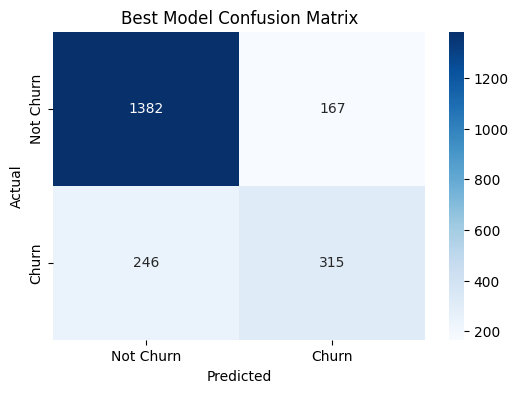

In [5]:
results_df = pd.DataFrame(results).T.sort_values('f1', ascending=False)
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON:")
print(results_df.drop('best_params', axis=1))

print("\n" + "="*50)
print(f"BEST MODEL: {results_df.index[0]}")
print(f"F1 Score: {best_f1:.4f}")

cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.title('Best Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

if hasattr(best_model, 'feature_importances_'):
    feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    top_features = feat_importances.nlargest(10)
    plt.figure(figsize=(10,6))
    top_features.plot(kind='barh')
    plt.title('Top 10 Feature Importances')
    plt.show()

FINAL REPORT

In [7]:
print("\n" + "="*50)
print("RECOMMENDATIONS FOR CELEBAL TECHNOLOGIES:")
print(f"- Best model: {results_df.index[0]} with F1-score of {best_f1:.4f}")
print(f"- Critical features driving churn: {', '.join(top_features.index[:3].tolist()) if 'top_features' in locals() else 'N/A'}")
print("- Actionable insights: Focus retention efforts on customers with:")
print("  * High monthly charges")
print("  * Month-to-month contracts")
print("  * Lack of online security services")


RECOMMENDATIONS FOR CELEBAL TECHNOLOGIES:
- Best model: Logistic Regression with F1-score of 0.6040
- Critical features driving churn: N/A
- Actionable insights: Focus retention efforts on customers with:
  * High monthly charges
  * Month-to-month contracts
  * Lack of online security services
